In [1]:
import numpy as np
import torch
from PIL import Image
import os
import matplotlib.pyplot as plt
from models.iufno import IU_FNO
from neuralop import LpLoss, H1Loss
from neuralop import Trainer
# from utils.trainer import Trainer
from neuralop.training import AdamW
from neuralop.models import FNO
from models.iufno import IU_FNO
from torch.utils.data import DataLoader

os.environ["CUDA_VISIBLE_DEVICES"]="0" 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from data.slice_image import load_trachea_slice_dataset
dataset = load_trachea_slice_dataset('../data/vmag_black', 'trachea', 300, 50, resolution=512, batch_size=4, test_batch_size=10, normalize=True, rgb=True)


Loading test db for resolution 512 with 50 samples 


In [3]:
dataset.train_db[0]['x'].size(), dataset.train_db[0]['y'].size()

(torch.Size([30, 512, 512]), torch.Size([3, 512, 512]))

In [4]:
train_loader = DataLoader(dataset.train_db, batch_size=4, num_workers=0, pin_memory=False, persistent_workers=False)
test_loader = DataLoader(dataset.test_dbs[512], batch_size=4, num_workers=0, pin_memory=False, persistent_workers=False)

In [5]:
model = IU_FNO(n_modes=(16, 16),
             in_channels=30,
             out_channels=3,
             hidden_channels=64, 
             projection_channel_ratio=2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)
train_loss =h1loss
eval_loss = {'h1' : h1loss}

In [6]:
trainer = Trainer(
    model = model,
    n_epochs = 100,
    device = device
)

In [ ]:
model.train()
trainer.train(
    train_loader = train_loader,
    test_loaders = {},
    optimizer = optimizer,
    scheduler = scheduler,
    regularizer = False,
    training_loss = train_loss,
    # eval_losses = eval_loss,
    save_every = 5,
    save_dir = '../checkpoints/'
)

In [7]:
model = IU_FNO(n_modes=(16, 16),
             in_channels=30,
             out_channels=3,
             hidden_channels=64, 
             projection_channel_ratio=2).to(device)
model.load_state_dict(torch.load('../checkpoints/model_state_dict.pt', weights_only=False))
model.eval()
# eval
torch.cuda.empty_cache()

data = next(iter(test_loader))
x = data['x'].to(device)
y = data['y'].to(device) * 255

y_pred = model(x) * 255

y = y.transpose(1,2).transpose(2,3).cpu().numpy().astype(np.uint8)
y_pred = y_pred.transpose(1,2).transpose(2,3).detach().cpu().numpy().astype(np.uint8)
y.shape, y_pred.shape

((4, 512, 512, 3), (4, 512, 512, 3))

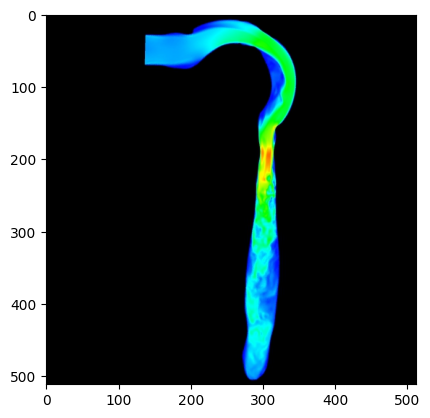

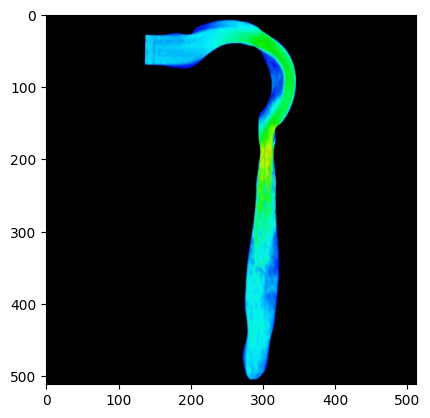

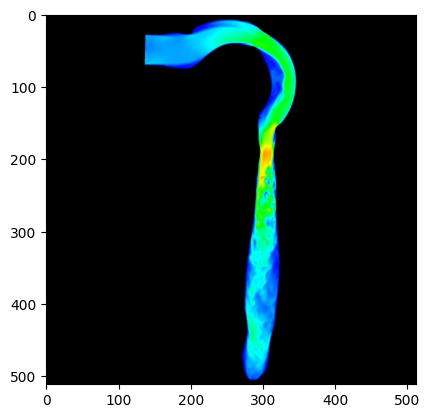

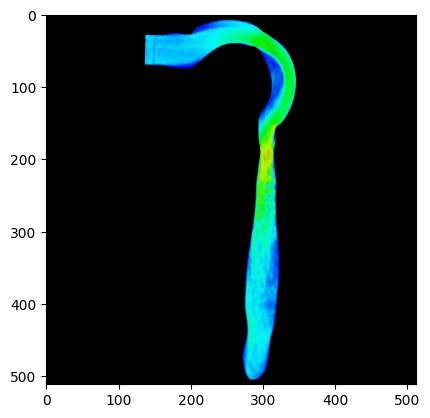

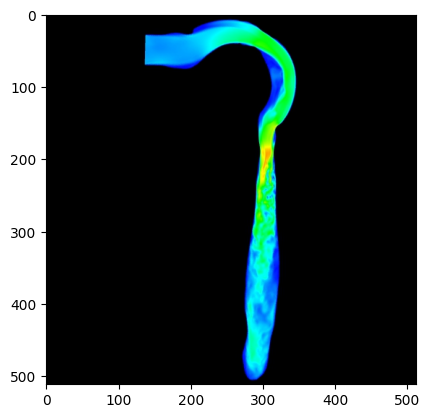

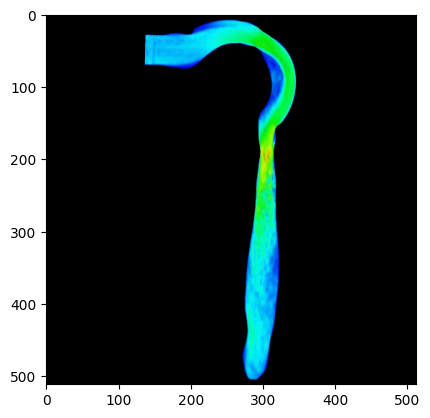

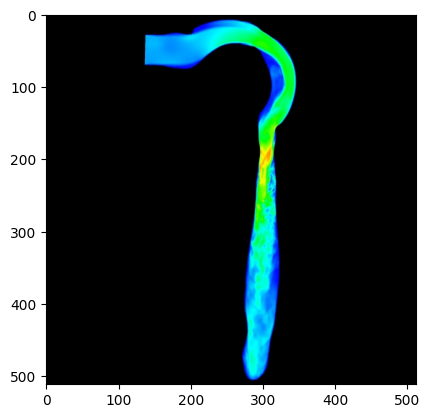

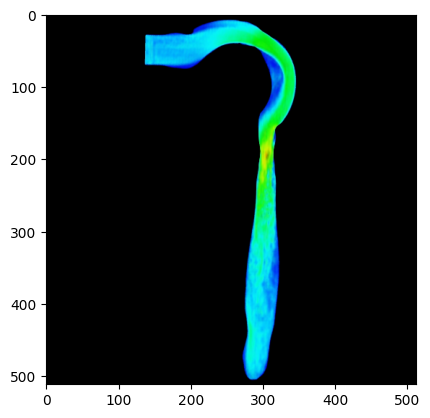

In [8]:
for i in range(0, 4):
    yy = y[i]
    yy_pred = y_pred[i]
    plt.imshow(yy)
    plt.show()
    plt.imshow(yy_pred)
    plt.show()